## BBC News Classification

Completed as part of CU Boulder's Unsupervised Algorithms in Machine Learning course.

In [176]:
# Project dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import re
import spacy
import itertools
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import accuracy_score
from collections import defaultdict
from scipy.sparse import csr_matrix
# Vectorizing word data
# importing all necessary modules
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')

import gensim
from gensim.models import Word2Vec

In [336]:
# Data import
train = pd.read_csv("data/BBC News Train.csv")
test = pd.read_csv("data/BBC News Test.csv")

### Exploratory Data Analysis (EDA)

In [120]:

print(train.head(5))
print("\nTrain:")
print(train.info())
print("\nTest:")
print(test.info())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0

In [79]:
# Check for any null/null-like values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

for df in [train, test]:
    for c in df.columns:
        string_null = np.array([x in null_like for x in df[c]])
        print(c, df[c].isnull().sum(), string_null.sum())

ArticleId 0 0
Text 0 0
Category 0 0
ArticleId 0 0
Text 0 0


In [337]:
# Top 20 most frequent words:
# ['the', '.', 'to', 'of', 'and', 'a', 'in', 's', 'for', 'is', 'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has', 'as']
# So we need to do some cleaning!


# Using helpers from: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in train['Text'])

t = time.time()

train['Clean Text'] = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Cleaned in: {} secs'.format(round((time.time() - t), 2)))

Cleaned in: 60.09 secs


In [19]:

# for installing missing corpora if needed
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [338]:
# iterate through each sentence in the file
tokens_by_idx = []
word_freq = defaultdict(int)

for idx, article in train.iterrows():
    text = article['Clean Text']
    for i in sent_tokenize(text):
        temp = []
        # tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j.lower())
            word_freq[j.lower()] += 1
        tokens_by_idx.append(temp)

# With stop words, unique word count was 28,178
print(len(word_freq))
print(tokens_by_idx[0],tokens_by_idx[20])

18437
['worldcom', 'ex', 'boss', 'launch', 'defence', 'lawyer', 'defend', 'worldcom', 'chief', 'bernie', 'ebber', 'battery', 'fraud', 'charge', 'call', 'company', 'whistleblow', 'witness', 'cynthia', 'cooper', 'worldcom', 's', 'ex', 'head', 'internal', 'accounting', 'alert', 'director', 'irregular', 'accounting', 'practice', 'telecom', 'giant', 'warning', 'lead', 'collapse', 'firm', 'follow', 'discovery', 'bn', 'bn', 'accounting', 'fraud', 'mr', 'ebber', 'plead', 'guilty', 'charge', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argue', 'mr', 'ebber', 'orchestrate', 'series', 'accounting', 'trick', 'worldcom', 'order', 'employee', 'hide', 'expense', 'inflate', 'revenue', 'meet', 'wall', 'street', 'earning', 'estimate', 'ms', 'cooper', 'run', 'consulting', 'business', 'tell', 'jury', 'new', 'york', 'wednesday', 'external', 'auditor', 'arthur', 'andersen', 'approve', 'worldcom', 's', 'accounting', 'early', 'say', 'andersen', 'give', 'green', 'light', 'procedure', 'practice', 'worldcom'

In [138]:
word_freq_sorted = sorted(word_freq, key=word_freq.get, reverse=True)
print("Top 20 most frequent:\n", word_freq_sorted[:20])

Top 20 most frequent:
 ['s', 'say', 'year', 'mr', 'new', 'people', 'm', 'good', 'win', 'time', 'game', 'film', 'world', 't', 'uk', 'come', 'government', 'play', 'go', 'work']


In [354]:

# Train Word2Vec model
bag_of_words_model = gensim.models.Word2Vec(tokens_by_idx, min_count=5, vector_size=100, window=3, epochs=40)

# Print results
print("Score 'lawyer' <-> 'defence': ", bag_of_words_model.wv.similarity('lawyer', 'defence'))

print("Score 'lawyer' <-> 'economy':", bag_of_words_model.wv.similarity('lawyer', 'economy'))

Score 'lawyer' <-> 'defence':  0.2428946
Score 'lawyer' <-> 'economy': -0.07808442


In [186]:
bag_of_words_model.wv.most_similar(positive=["economy"])

[('economic', 0.9935590624809265),
 ('spending', 0.9910126328468323),
 ('figure', 0.9864799976348877),
 ('taxis', 0.9825592041015625),
 ('cut', 0.9806527495384216),
 ('income', 0.9800869822502136),
 ('raise', 0.9789696335792542),
 ('bank', 0.9781836271286011),
 ('deficit', 0.9772624373435974),
 ('country', 0.9765828847885132)]

In [128]:
sorted_counts = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

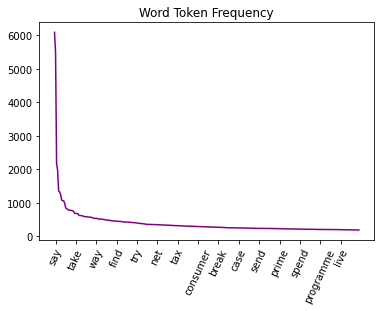

In [187]:

x, y = zip(*sorted_counts[:300]) # unpack a list of pairs into two tuples

plt.plot(x, y, color="purple")
plt.title("Word Token Frequency")
plt.xticks(np.arange(1, 300, 20.0), rotation = 65)
plt.show()

In [355]:
# lastly, we need to prepare vectors for our articles, not just words
# useful resource: https://blog.eduonix.com/artificial-intelligence/converting-word-vectors-document-vectors-using-gensim-library/
doc_vectors = []
min_val = 0

for idx, article in train.iterrows():
    tokens = tokens_by_idx[idx]
    zero_vector = np.zeros(bag_of_words_model.vector_size)
    vectors = []
    for token in tokens:
        if token in bag_of_words_model.wv:
            try:
                vectors.append(bag_of_words_model.wv[token])
            except KeyError:
                continue
    if vectors:
        vectors = np.asarray(vectors)
        avg_vec = vectors.mean(axis=0)
        if min(avg_vec) < min_val:
            min_val = min(avg_vec)
        doc_vectors.append(avg_vec)
    else:
        doc_vectors.append(zero_vector)

train_vectors = train[['ArticleId']].copy()
train_vectors['Vectors'] = doc_vectors


In [356]:
# Shift all values to be positive
pos_vectors = []
for vector in doc_vectors:
    pos_vectors.append(vector + abs(min_val))
print(pos_vectors[:2])

[array([0.8863976 , 1.8767757 , 1.9353137 , 1.7304355 , 2.0393772 ,
       1.2551463 , 1.2515088 , 2.0416667 , 1.7298709 , 1.9925706 ,
       1.281667  , 1.2552978 , 1.3330688 , 1.6340147 , 1.3161261 ,
       1.4229617 , 1.9519684 , 1.0312808 , 1.2097414 , 1.6228107 ,
       1.4062114 , 1.7677444 , 1.9340491 , 1.8739758 , 1.548852  ,
       1.4373631 , 1.3194989 , 1.6017755 , 1.3006411 , 1.4830455 ,
       1.9124548 , 1.5291111 , 1.2069255 , 0.845374  , 1.5702043 ,
       1.9728563 , 2.1842308 , 1.3186527 , 1.5257792 , 1.4777999 ,
       2.0063097 , 1.3860914 , 1.5514451 , 0.77395564, 1.9253343 ,
       1.9359462 , 1.1308306 , 1.0777054 , 1.8742064 , 1.5240506 ,
       1.5867352 , 1.2750415 , 1.7263677 , 1.3411274 , 1.5212865 ,
       2.1543179 , 1.4731293 , 1.6157598 , 0.77977383, 1.5409219 ,
       0.77041066, 1.1910465 , 1.7839032 , 1.5483985 , 1.3814892 ,
       1.4644842 , 1.444418  , 1.6757306 , 1.3381417 , 1.8400769 ,
       0.9726956 , 1.6894147 , 1.5727724 , 1.4271151 , 1.4021

### Unsupervised Model

In [190]:
# We are looking to categorize into 5 labels
print(train['Category'].unique())

['business' 'tech' 'politics' 'sport' 'entertainment']


In [357]:

train_mat = csr_matrix(pos_vectors)

# svd_model = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
# svd_model.fit(train_mat)
nmf_mod = NMF(n_components=5, init='nndsvda', solver = 'mu', beta_loss = 'kullback-leibler',
                l1_ratio = 0.5, random_state = 400)
nmf_mod.fit(train_mat)

NMF(beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.5, n_components=5,
    random_state=400, solver='mu')

In [366]:
def predict(weights):
    sortedW = np.argsort(weights)
    k, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(k)]
    topics = np.empty(k, dtype = np.int64)
    for i in range(k):
        topics[i] = predictions[i][0]
    return topics

def best_labels(df, y_pred):
    """
    Returns label indices
    Example output: (1,2,3,5,4), 0.5
    """
    categories = ['business','tech','politics','sport','entertainment']
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))
    acc = 0
    best_perm = []
    current = {}
    for perm in perms:
        for i in range(len(categories)):
            current[categories[i]] = perm[i]
            if len(current) == 5:
                df['test'] = df['Category'].map(current)
                current_accuracy = accuracy_score(df['test'], y_pred)
                if current_accuracy > acc:
                    acc = current_accuracy
                    best_perm = perm
                    df['Predicted'] = df['test']
    df = df.drop(columns=["test"])
    return best_perm, acc

In [367]:
y_transform = predict(nmf_mod.transform(train_mat))
label_order, accuracy = best_labels(train, y_transform)
print('accuracy=', accuracy)
# vector_size 50: 0.701
# vector_size 75: 0.7
# vector_size 100: 0.742 (window size: 3)
# vector_size 125: 0.710

# vector_size: 100, window size: 4, min_count: 5
# 0.714
# vector_size: 100, window size: 2
# 0.672

# min_count 10
# 0.506
# min_count 3
# 0.6637

# epochs 5 -> 10
# 0.5711
# epochs 20
# 0.700
# epochs 40
# 0.726
# epochs 50
# 0.711


accuracy= 0.7261744966442953


In [170]:
explained_variance = svd_model.explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 96.8%


### Comparing to Supervised Model